In [9]:
import pandas as pd
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))
from models.random_forrest import random_forrest_session
from models.random_forrest import run_backtest
notebook_path = os.path.abspath(os.path.join(os.getcwd(), '../notebooks'))
input_file_path = rf'{notebook_path}\data\processed\session'
model_output_filepath = rf'{notebook_path}\output\model'

c:\Users\mmori\Documents\fx_strategy_project\src\models\random_forrest.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['datetime'] = pd.to_datetime(df['datetime'], errors='raise')


Unique session days: 257
Training days: 154, Testing days: 51, Backtesting days: 52
{'Accuracy': 0.5236593059936908, 'Confusion Matrix': array([[161, 156],
       [146, 171]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.52      0.51      0.52       317\n           1       0.52      0.54      0.53       317\n\n    accuracy                           0.52       634\n   macro avg       0.52      0.52      0.52       634\nweighted avg       0.52      0.52      0.52       634\n'}
Index(['tick_number', 'price', 'actual_openprice', 'ticks_moved', 'directions',
       'fx_return', 'day_of_week', 'datetime_original', 'lag_1', 'lag_2',
       'lag_3', 'ticks_moved_lag_1', 'target', 'date'],
      dtype='object')
Test set size: 588
     tick                   datetime    price  predicted  actual  fx_return  \
0    5904  2023-10-18 07:31:00-04:00  1.21915          1       1   0.094416   
1    5905  2023-10-18 08:19:00-04:00  1.22015      

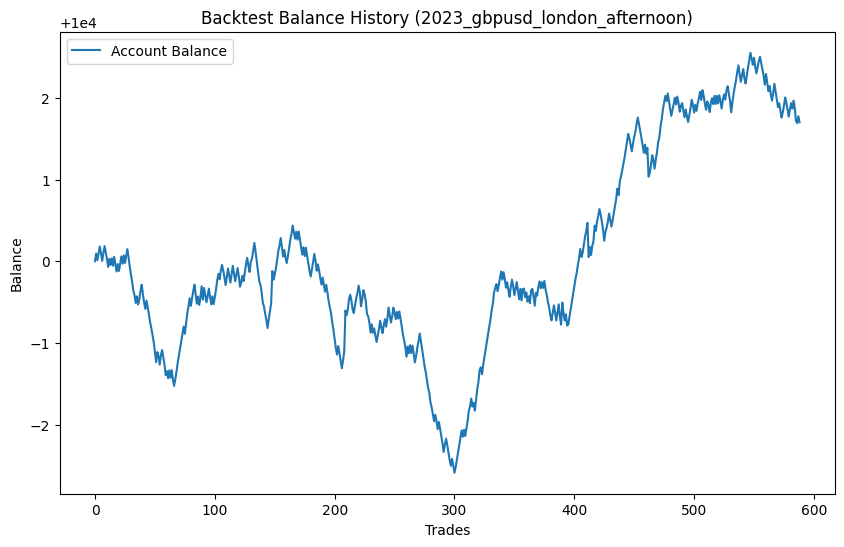

In [10]:
# Step 1: Loading the Data
year = "2023"
ccy = "gbpusd"
session = "london_afternoon"
file_path = rf'{input_file_path}/{year}_{ccy}_{session}_tick_prev_price_as_base.csv'
# Load the dataset
df = pd.read_csv(file_path)
backtest_data, X_backtest, y_backtest, y_pred_backtest = random_forrest_session(df, year, ccy, session, model_output_filepath)
balance_history, trade_log = run_backtest(model_output_filepath, year, ccy, session, backtest_data, X_backtest, y_backtest, y_pred_backtest)

Test set size: 588
     tick                   datetime    price  predicted  actual  fx_return  \
0    5904  2023-10-18 07:31:00-04:00  1.21915          1       1   0.094416   
1    5905  2023-10-18 08:19:00-04:00  1.22015          0       1   0.082024   
2    5906  2023-10-18 08:36:00-04:00  1.21915          1       0  -0.086874   
3    5907  2023-10-18 08:42:00-04:00  1.21815          1       0  -0.081207   
4    5908  2023-10-18 08:47:00-04:00  1.21715          0       0  -0.081273   
..    ...                        ...      ...        ...     ...        ...   
583  7253  2023-12-29 10:46:00-05:00  1.27315          0       0  -0.089487   
584  7254  2023-12-29 10:48:00-05:00  1.27415          0       1   0.158706   
585  7255  2023-12-29 11:02:00-05:00  1.27515          0       1   0.027455   
586  7256  2023-12-29 11:05:00-05:00  1.27415          1       0  -0.084695   
587  7257  2023-12-29 11:33:00-05:00  1.27315          0       0  -0.073779   

       profit       balance  
0 

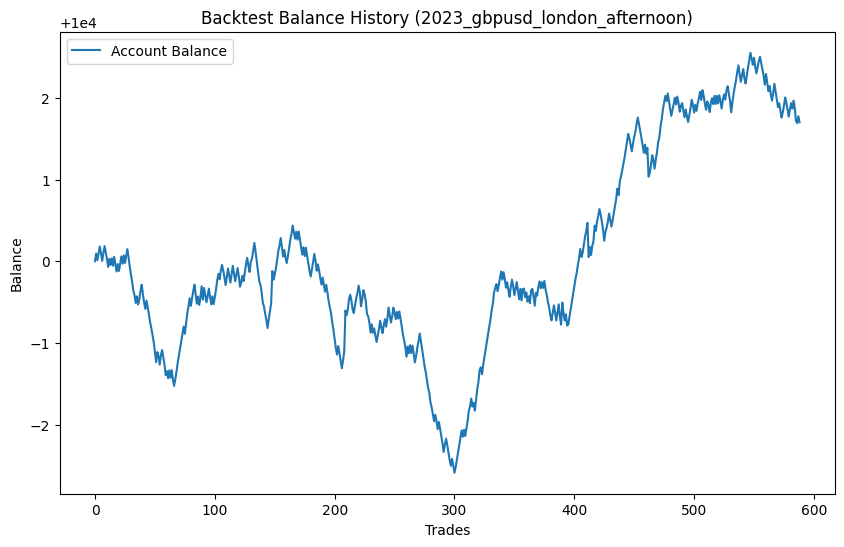

In [ ]:
%debug
year = "2024"
ccy = "usdjpy"
sessions = ["ny", "ny_morning", "ny_evening", "london", "london_morning", "london_afternoon", "asian", "asian_morning"]
base_price = "prev"

for session in sessions:
    file_path = rf'{input_file_path}/{year}_{ccy}_{session}_tick_prev_{base_price}_as_base.csv'
    # Load the dataset
    df = pd.read_csv(file_path)
    backtest_data, X_backtest, y_backtest, y_pred_backtest = random_forrest_session(df, year, ccy, session)
    print(f'model for {session} completed')
    balance_history, trade_log = run_backtest(backtest_data, X_backtest, y_backtest, y_pred_backtest)
    print(f'backtest for {session} completed')
